# Predicting rate of death
The CDC [reports](https://www.kaggle.com/datasets/cdc/nchs-death-rates-and-causes-of-death) death rates in all US states due to various causes such as heart disease, Alzheimer's, etc.

This notebook is an effort to find the features which predict those rates. I am using [Census Bureau nonemployer establishment data](https://www.census.gov/programs-surveys/nonemployer-statistics/data/datasets.html#:~:text=Nonemployer%20Statistics%20Datasets,-Nonemployer%20Statistics%20(NES&text=NES%20data%20includes%20the%20number,geographic%20area%20and%20industry%20detail.) as my first attempt. A nonemployer estabishment is a business without any employees.

Death rates are measured as the number of deaths per 100,000 people.

The data is for year 2017.

This is a work-in-progress. I have gotten as far as preparing the feature set. My next steps are to apply these models:
* Linear regression (with feature encoding).
* Naive Bayes.
* Decision trees (with [XGBoost](https://xgboost.readthedocs.io/en/stable/)).

In [235]:
import csv
import datetime
import itertools
import math
import os
import pickle
import re
import subprocess
# Imports above are standard library
# Imports below are 3rd-party
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, recall_score, precision_score, silhouette_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from statsmodels.api import qqplot
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import statsmodels.api as sm
from xgboost import XGBClassifier, plot_importance

## Kaggle API
You will need your own API key, which you can get by following instructions at https://github.com/Kaggle/kaggle-api/blob/main/docs/README.md

In [236]:
os.environ["KAGGLE_USERNAME"] = "jsf80238"
os.environ["KAGGLE_KEY"] = "4036359324650e1c13adfc7ba87ff90e"
import kaggle  # The import itself uses your KAGGLE_KEY, that's why the import is not at the top. Really.

dataset_name = "NCHS - Death Rates and Causes of Death"
command = "kaggle datasets list --csv --search".split()
#command.append("NCHS - Death Rates and Causes of Death")
result = subprocess.run(command + [dataset_name], capture_output=True)
data = result.stdout.decode(encoding="utf-8")
data[:100]

'ref,title,size,lastUpdated,downloadCount,voteCount,usabilityRating\r\ncdc/nchs-death-rates-and-causes-'

In [237]:
csvreader = csv.DictReader(data.splitlines())
for row in csvreader:
    if row["title"] == dataset_name:
        print(row)
        dataset_ref = row['ref']
        break
dataset_ref

{'ref': 'cdc/nchs-death-rates-and-causes-of-death', 'title': 'NCHS - Death Rates and Causes of Death', 'size': '3MB', 'lastUpdated': '2019-12-28 01:24:17', 'downloadCount': '1559', 'voteCount': '14', 'usabilityRating': '0.7647059'}


'cdc/nchs-death-rates-and-causes-of-death'

In [238]:
dataset_ref = "cdc/nchs-death-rates-and-causes-of-death"
file_name = "nchs-leading-causes-of-death-united-states.csv"
command = f"kaggle datasets download --unzip --force --file {file_name} {dataset_ref}".split()
result = subprocess.run(command, capture_output=True)
stdout = result.stdout.decode(encoding="utf-8")
stderr = result.stderr.decode(encoding="utf-8")
print(stdout)
print(stderr)
print(os.linesep.join(sorted(os.listdir("."))))

Dataset URL: https://www.kaggle.com/datasets/cdc/nchs-death-rates-and-causes-of-death
License(s): other


100%|██████████| 834k/834k [00:00<00:00, 3.04MB/s]

.ipynb_checkpoints
census.df
death_rate.ipynb
nchs-age-adjusted-death-rates-for-selected-major-causes-of-death.csv
nchs-leading-causes-of-death-united-states.csv
nchs-leading-causes-of-death-united-states.df
socrata_metadata_nchs-age-adjusted-death-rates-for-selected-major-causes-of-death.json
socrata_metadata_nchs-death-rates-and-life-expectancy-at-birth.json
socrata_metadata_nchs-leading-causes-of-death-united-states.json
socrata_metadata_nchs-potentially-excess-deaths-from-the-five-leading-causes-of-death.json
socrata_metadata_nchs-top-five-leading-causes-of-death-united-states-1990-1950-2000.json


### Kaggle workaround
If you were unable to download the cause-of-death file you can also grab it from my GitHub repo:

https://github.com/jsf80238/data_science/blob/main/data_files/nchs-leading-causes-of-death-united-states.csv

In [239]:
df = pd.read_csv(file_name)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10868 entries, 0 to 10867
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     10868 non-null  int64  
 1   113 Cause Name           10868 non-null  object 
 2   Cause Name               10868 non-null  object 
 3   State                    10868 non-null  object 
 4   Deaths                   10868 non-null  int64  
 5   Age-adjusted Death Rate  10868 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 509.6+ KB


In [240]:
save_file = "nchs-leading-causes-of-death-united-states.df"
# with open(save_file, "wb") as writer:
#     pickle.dump(df, writer)

with open(save_file, "rb") as reader:
    df = pickle.load(reader)

print(f"{df.shape[0]:,} rows")
df.head(2)

10,868 rows


,Year,113 Cause Name,Cause Name,State,Deaths,Age-adjusted Death Rate
0,2012,"Nephritis, nephrotic syndrome and nephrosis (N...",Kidney disease,Vermont,21,2.6
1,2017,"Nephritis, nephrotic syndrome and nephrosis (N...",Kidney disease,Vermont,29,3.3


In [241]:
df.drop(columns=["113 Cause Name", "Deaths"], inplace=True)
name_dict = {
    "Year": "year",
    "Cause Name": "cause",
    "State": "state_name",
    "Age-adjusted Death Rate": "death_rate",
}
df.rename(columns=name_dict, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10868 entries, 0 to 10867
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        10868 non-null  int64  
 1   cause       10868 non-null  object 
 2   state_name  10868 non-null  object 
 3   death_rate  10868 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 339.8+ KB


## Adjustments
In case 2017 was an especially good or bad year, use the average from 2010-2017.

Also, eliminate the rows which report deaths for the entire United States.

In [242]:
mask = (df["year"] >= 2010) & (df["state_name"] != 'United States')
df = df[mask]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4488 entries, 0 to 10802
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        4488 non-null   int64  
 1   cause       4488 non-null   object 
 2   state_name  4488 non-null   object 
 3   death_rate  4488 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 175.3+ KB


In [243]:
df = df[["state_name", "cause", "death_rate"]].groupby(["state_name", "cause"]).mean().reset_index()
df

,state_name,cause,death_rate
0,Alabama,All causes,924.6125
1,Alabama,Alzheimer's disease,35.2625
2,Alabama,CLRD,55.5750
3,Alabama,Cancer,180.5125
4,Alabama,Diabetes,22.6875
...,...,...,...
556,Wyoming,Influenza and pneumonia,17.5750
557,Wyoming,Kidney disease,11.7625
558,Wyoming,Stroke,33.2625
559,Wyoming,Suicide,24.6750


## Add a normalized death rate
A state may have a higher death rate across-the-board, or may have a higher death rate for particular causes, or both.

Divide the death rates for particular causes by the death rate for that state to better isolate particular causes.

In [244]:
death_rate_all_causes = "death_rate_all_causes"
all_causes = "All causes"
mask = (df["cause"] == all_causes)
by_state_df = df[mask][["state_name", "death_rate"]]
print(f"{by_state_df.shape[0]:,} rows")
by_state_df.head(2)

51 rows


,state_name,death_rate
0,Alabama,924.6125
11,Alaska,739.2125


In [245]:
df = df.merge(by_state_df, on="state_name", suffixes=(None, "_all_causes"))
df["death_rate_normalized"] = df["death_rate"] / df[death_rate_all_causes]
df.drop(columns=[death_rate_all_causes], inplace=True)
print(f"{df.shape[0]:,} rows")
df.head(2)

561 rows


,state_name,cause,death_rate,death_rate_normalized
0,Alabama,All causes,924.6125,1.000000
1,Alabama,Alzheimer's disease,35.2625,0.038138


### We don't need all-causes rows anymore

In [246]:
mask = (df["cause"] != all_causes)
df = df[mask]
print(f"{df.shape[0]:,} rows")
df.head(2)

510 rows


,state_name,cause,death_rate,death_rate_normalized
1,Alabama,Alzheimer's disease,35.2625,0.038138
2,Alabama,CLRD,55.5750,0.060106


## Census data
Nonemployer Statistics provides annual statistics on U.S. businesses with no paid employees or payroll at a detailed geography and industry level.

Statistics are available on businesses that have no paid employment or payroll, are subject to federal income taxes, and have receipts of $1,000 or more ($1 or more for the Construction sector). The data are available for approximately 450 NAICS industries at the national, state, county, metropolitan statistical area, and combined statistical area geography levels. The majority of NAICS industries are included.

https://www.census.gov/data/developers/data-sets/nonemp-api.2017.html#list-tab-1358655114

https://www.census.gov/data/developers/data-sets/nonemp-api.html
https://api.census.gov/data/2017/nonemp/variables.html

https://www2.census.gov/programs-surveys/nonemployer-statistics/technical-documentation/record-layouts/state-record-layout/state_record_layout_2017.txt

### Definitions
* LFO = Legal form of organization
* NAICS2017_LABEL = type of business
* NAME = geo areas, including states
* NESTAB = Number of nonemployer establishments
* NRCPTOT = Nonemployer sales, value of shipments, or revenue ($1,000)
* RCPSZES_LABEL = Separates establishments into groups by sales/receipts, including "All establishments"

In [247]:
CENSUS_API_KEY = "35b2edd7f868b6d6f79e5988091d0f8df6ffbd2a"

In [248]:
CENSUS_DEMOGRAPHICS_URL = "https://api.census.gov/data/2019/pep/charagegroups"
param_dict = {'get': 'NAME,POP', 'for': 'state:*', "key": CENSUS_API_KEY}

In [249]:
response = requests.get(CENSUS_DEMOGRAPHICS_URL, params=param_dict)

In [250]:
result_list = response.json()  # The return from the API call is a list of lists, with first item being the column names
column_name_list = result_list.pop(0)
states_df = pd.DataFrame(result_list, columns=column_name_list)
states_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NAME    52 non-null     object
 1   POP     52 non-null     object
 2   state   52 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB


In [251]:
name_dict = {
    "NAME": "state_name",
    "POP": "population",
    "state": "state_key",
}
states_df.rename(columns=name_dict, inplace=True)
states_df["population"] = states_df["population"].astype(int)
states_df["state_key"] = states_df["state_key"].astype(int)
states_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   state_name  52 non-null     object
 1   population  52 non-null     int64 
 2   state_key   52 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ KB


In [252]:
states_df["population"].sum()  # Expected value ~330 million

331433217

In [253]:
df = df.merge(states_df, on="state_name", how="inner")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state_name             510 non-null    object 
 1   cause                  510 non-null    object 
 2   death_rate             510 non-null    float64
 3   death_rate_normalized  510 non-null    float64
 4   population             510 non-null    int64  
 5   state_key              510 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 24.0+ KB


In [254]:
CENSUS_NONEMPLOYER_URL = "https://api.census.gov/data/2017/nonemp"
param_dict = {'get': ','.join(("LFO", "NESTAB", "NRCPTOT")), 'for': 'state:*', "NAICS2017": '*', "key": CENSUS_API_KEY}

In [255]:
save_file = "census.df"
# with open(save_file, "wb") as writer:
#     pickle.dump(business_df, writer)

with open(save_file, "rb") as reader:
    business_df = pickle.load(reader)

business_df

,LFO,NESTAB,NRCPTOT,NAICS2017,state
0,001,219596,8889009,00,28
1,9101,1750,206357,00,28
2,9111,6527,848178,00,28
3,920,198380,6220549,00,28
4,930,12939,1613925,00,28
...,...,...,...,...,...
109376,001,4930,58618,813,18
109377,9101,49,1913,813,18
109378,9111,9,360,813,18
109379,920,4864,56215,813,18


In [256]:
name_dict = {
    "state": "state_key",
    "NAICS2017": "business_type",
    "LFO": "legal_form",
    "NESTAB": "establishment_count",
    "NRCPTOT": "revenue_in_thousands",
}
business_df.rename(columns=name_dict, inplace=True)
business_df = business_df.reindex(["state_key", "legal_form", "business_type", "establishment_count", "revenue_in_thousands"], axis=1)
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109381 entries, 0 to 109380
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   state_key             109381 non-null  object
 1   legal_form            109381 non-null  object
 2   business_type         109381 non-null  object
 3   establishment_count   109381 non-null  object
 4   revenue_in_thousands  109381 non-null  object
dtypes: object(5)
memory usage: 4.2+ MB


## Eliminate redudant legal form rows
Census rows with a legal form of "All" ("001") are summaries of the other rows.

In [257]:
mask = (business_df["legal_form"] != "001")
business_df = business_df[mask]
business_df.shape

(85555, 5)

## Eliminate redudant business type rows
The Census data contains rows for multiple levels, some of which are partially duplicative, for example:
| Code | Name |
| --- | --- |
| 11 | Agriculture, Forestry, Fishing and Hunting |
| 111 | Crop Production |
| 1111 | Oilseed and Grain Farming |
| 11111 | Soybean Farming |
| 111110 | Soybean Farming |
| 11112 | Oilseed (except Soybean) Farming |
| 111120 | Oilseed (except Soybean) Farming |
| 11113 | Dry Pea and Bean Farming |
| 111130 | Dry Pea and Bean Farming |

Although somewhat arbitrary, the 3-digit codes make the most sense to me.

In [258]:
mask = (business_df["business_type"].str.len() == 3)
business_df = business_df[mask]
business_df.shape

(15708, 5)

## Convert numeric-like values to numerics

In [259]:
for column_name in "establishment_count", "revenue_in_thousands", "state_key":
    business_df[column_name] = business_df[column_name].astype(int)
business_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15708 entries, 11 to 109380
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   state_key             15708 non-null  int64 
 1   legal_form            15708 non-null  object
 2   business_type         15708 non-null  object
 3   establishment_count   15708 non-null  int64 
 4   revenue_in_thousands  15708 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 736.3+ KB


In [260]:
business_df

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
11,28,9101,113,19,2091
12,28,9111,113,53,7736
13,28,920,113,1284,72984
14,28,930,113,70,8958
16,28,9101,114,36,5920
...,...,...,...,...,...
109289,18,930,812,648,58468
109377,18,9101,813,49,1913
109378,18,9111,813,9,360
109379,18,920,813,4864,56215


## Check for duplicate rows

In [261]:
mask = business_df[["state_key", "business_type", "legal_form"]].duplicated()
business_df[mask]

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands


## Check for holes
Verify this data does not have holes, meaning verify every combination of legal_form/business_type exists for every state.

If something is missing, add it with np.nan for the establishment_count and revenue.

In [262]:
state_list = business_df["state_key"].unique()
legal_form_list = business_df["legal_form"].unique()
business_type_list = business_df["business_type"].unique()
wanted_combinations_set = set(itertools.product(state_list, legal_form_list, business_type_list))
print(f"{len(wanted_combinations_set):,} possible combinations, for example:")
for i, item in enumerate(wanted_combinations_set):
    print(item)
    if i > 10:
        break


16,728 possible combinations, for example:
(50, '930', '624')
(40, '930', '711')
(47, '9101', '424')
(11, '9111', '454')
(31, '920', '611')
(40, '920', '331')
(22, '920', '332')
(23, '930', '423')
(2, '930', '323')
(31, '9111', '611')
(15, '930', '488')
(33, '930', '487')


In [263]:
existing_combinations_set = set()
for item in business_df[["state_key", "legal_form", "business_type"]].to_records(index=False):
    existing_combinations_set.add(tuple(item))
print(f"{len(existing_combinations_set):,} existing combinations, for example:")
for i, item in enumerate(existing_combinations_set):
    print(item)
    if i > 10:
        break

15,708 existing combinations, for example:
(50, '930', '624')
(40, '930', '711')
(47, '9101', '424')
(11, '9111', '454')
(40, '920', '331')
(31, '920', '611')
(22, '920', '332')
(23, '930', '423')
(2, '930', '323')
(31, '9111', '611')
(15, '930', '488')
(33, '930', '487')


In [264]:
missing_combinations_set = wanted_combinations_set - existing_combinations_set
print(f"{len(missing_combinations_set):,} missing combinations, for example:")
for i, item in enumerate(missing_combinations_set):
    print(item)
    if i > 10:
        break

1,020 missing combinations, for example:
(9, '9101', '316')
(8, '9101', '314')
(11, '9101', '313')
(12, '9101', '211')
(47, '9111', '316')
(33, '9101', '492')
(10, '920', '324')
(11, '930', '321')
(45, '9101', '316')
(11, '9111', '337')
(47, '9101', '313')
(31, '9101', '313')


In [265]:
missing_data = [list(combo) + [np.nan, np.nan] for combo in missing_combinations_set]
missing_data[:10]

[[9, '9101', '316', nan, nan],
 [8, '9101', '314', nan, nan],
 [11, '9101', '313', nan, nan],
 [12, '9101', '211', nan, nan],
 [47, '9111', '316', nan, nan],
 [33, '9101', '492', nan, nan],
 [10, '920', '324', nan, nan],
 [11, '930', '321', nan, nan],
 [45, '9101', '316', nan, nan],
 [11, '9111', '337', nan, nan]]

In [266]:
missing_df = pd.DataFrame.from_records(missing_data)
missing_df.columns = ["state_key", "legal_form", "business_type", "establishment_count", "revenue_in_thousands"]
missing_df

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
0,9,9101,316,NaN,NaN
1,8,9101,314,NaN,NaN
2,11,9101,313,NaN,NaN
3,12,9101,211,NaN,NaN
4,47,9111,316,NaN,NaN
...,...,...,...,...,...
1015,20,9111,483,NaN,NaN
1016,2,9111,334,NaN,NaN
1017,54,9101,446,NaN,NaN
1018,4,9101,113,NaN,NaN


In [267]:
business_df = pd.concat([business_df, missing_df], ignore_index=True)
business_df

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
0,28,9101,113,19.0,2091.0
1,28,9111,113,53.0,7736.0
2,28,920,113,1284.0,72984.0
3,28,930,113,70.0,8958.0
4,28,9101,114,36.0,5920.0
...,...,...,...,...,...
16723,20,9111,483,NaN,NaN
16724,2,9111,334,NaN,NaN
16725,54,9101,446,NaN,NaN
16726,4,9101,113,NaN,NaN


## Merge cause of death data with business data

In [268]:
df = df.merge(business_df, on="state_key", how="inner")
print(f"{df.shape[0]:,} rows")
df.head(2)

167,280 rows


,state_name,cause,death_rate,death_rate_normalized,population,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
0,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9101,113,13.0,1959.0
1,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9111,113,45.0,7584.0


## Adjust for population
We would expect the number of establishments and revenue to be higher in more populous states.

Adjust.

In [269]:
df["establishments_per_person"] = df["establishment_count"] / df["population"]
df["revenue_per_person"] = df["revenue_in_thousands"] * 1000 / df["population"]
print(f"{df.shape[0]:,} rows")
df.head(2)

167,280 rows


,state_name,cause,death_rate,death_rate_normalized,population,state_key,legal_form,business_type,establishment_count,revenue_in_thousands,establishments_per_person,revenue_per_person
0,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9101,113,13.0,1959.0,0.000003,0.399536
1,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9111,113,45.0,7584.0,0.000009,1.546750


## Multicollinearity
Collinearity among indepedent variables is fatal for regression models and not helpful for other models.

<Axes: >

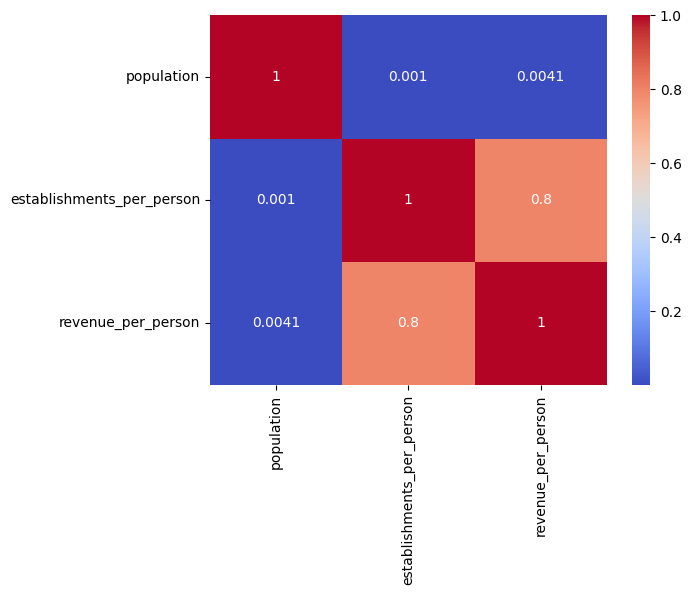

In [270]:
potential_suspects_df = df[["population", "establishments_per_person", "revenue_per_person"]]
correlation_matrix = potential_suspects_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

The result above means Establishments and Revenue are very highly correlated, so we should not use one.

Perhaps revenue per establishment might be a different, uncorrelated independent variable we could use?

<Axes: >

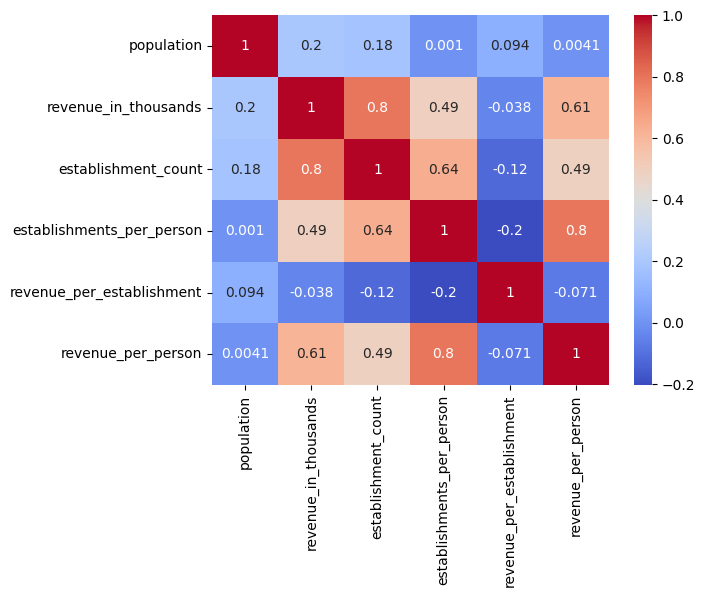

In [271]:
df["revenue_per_establishment"] = df["revenue_in_thousands"] * 1000 / df["establishment_count"]

more_suspects_df = df[["population", "revenue_in_thousands", "establishment_count", "establishments_per_person", "revenue_per_establishment", "revenue_per_person"]]
correlation_matrix = more_suspects_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

We are going to pick 0.6 as the threshold, meaning we will drop revenue and revenue per person.

In [272]:
df.drop(columns=["revenue_in_thousands", "revenue_per_person"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167280 entries, 0 to 167279
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   state_name                 167280 non-null  object 
 1   cause                      167280 non-null  object 
 2   death_rate                 167280 non-null  float64
 3   death_rate_normalized      167280 non-null  float64
 4   population                 167280 non-null  int64  
 5   state_key                  167280 non-null  int64  
 6   legal_form                 167280 non-null  object 
 7   business_type              167280 non-null  object 
 8   establishment_count        157080 non-null  float64
 9   establishments_per_person  157080 non-null  float64
 10  revenue_per_establishment  141330 non-null  float64
dtypes: float64(5), int64(2), object(4)
memory usage: 14.0+ MB


## Categorization of data
Let's make population, establishment_per_person and revenue_per_person categories

Distribution plots will help us decide how to make the cuts.

In [273]:
# LEGAL_FORM_URL = "https://raw.githubusercontent.com/jsf80238/data_science/main/data_files/legal_form_codes.csv"
# response = requests.get(LEGAL_FORM_URL)
# line_list = response.text.splitlines()

# legal_form_dict = dict()
# csvreader = csv.DictReader(line_list)
# label_for_keys, label_for_values = csvreader.fieldnames
# for row in csvreader:
#     legal_form_dict[row[label_for_keys]] = row[label_for_values]

# df["legal_form"] = df["legal_form"].apply(lambda x: legal_form_dict.get(x))

# BUSINESS_TYPE_URL = "https://raw.githubusercontent.com/jsf80238/data_science/main/data_files/naics_codes.csv"
# response = requests.get(BUSINESS_TYPE_URL)
# line_list = response.text.splitlines()

# business_type_dict = dict()
# csvreader = csv.DictReader(line_list)
# label_for_keys, label_for_values = csvreader.fieldnames
# for row in csvreader:
#     business_type_dict[row[label_for_keys]] = row[label_for_values]

# df["business_type"] = df["business_type"].apply(lambda x: business_type_dict.get(x))

# with open("data_for_visualization.csv", "wb") as writer:
#     pickle.dump(df.to_csv(), writer)

7 for population.
41 for establishments_per_person.
46 for revenue_per_establishment.


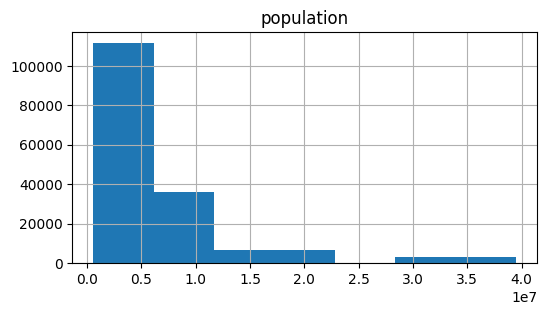

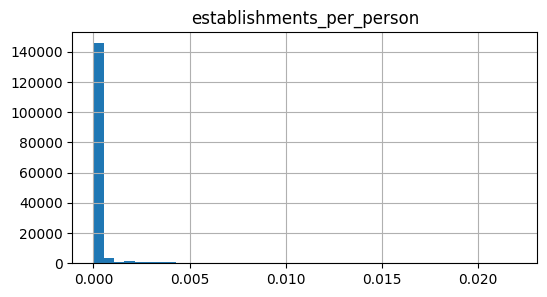

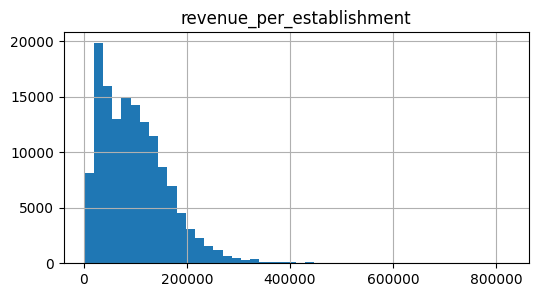

In [274]:
for column_name in "population", "establishments_per_person", "revenue_per_establishment":
    number_of_observations = df[column_name].nunique()
    # Rice's rule
    suggested_bin_count = int(math.cbrt(number_of_observations)*2)
    print(f"{suggested_bin_count} for {column_name}.")
    df.hist(column=column_name, bins=suggested_bin_count, figsize=(6, 3))

### Binning conclusion
Population: 7 cuts based on absolute population

Establishments and revenue per establishment: 7 cuts with equal numbers of observations in each bin

In [275]:
XXSMALL = "xx-small"
XSMALL = "x-small"
SMALL = "small"
MEDIUM = "medium"
LARGE = "large"
XLARGE = "x-large"
XXLARGE = "xx-large"

df["population_bin"] = pd.cut(df["population"], 7, labels=[XXSMALL, XSMALL, SMALL, MEDIUM, LARGE, XLARGE, XXLARGE])
df["establishments_bin"] = pd.qcut(df["establishments_per_person"], 7, labels=[XXSMALL, XSMALL, SMALL, MEDIUM, LARGE, XLARGE, XXLARGE])
df["revenue_per_establishment_bin"] = pd.qcut(df["revenue_per_establishment"], 7, labels=[XXSMALL, XSMALL, SMALL, MEDIUM, LARGE, XLARGE, XXLARGE])

for column_name in "population_bin", "establishments_bin", "revenue_per_establishment_bin":
    print(df[column_name].value_counts())

print(f"{df.shape[0]:,} rows")
df.head(2)

population_bin
xx-small    111520
x-small      36080
small         6560
medium        6560
x-large       3280
xx-large      3280
large            0
Name: count, dtype: int64
establishments_bin
xx-small    22510
medium      22450
x-large     22440
xx-large    22440
small       22430
large       22430
x-small     22380
Name: count, dtype: int64
revenue_per_establishment_bin
xx-small    20190
x-small     20190
small       20190
medium      20190
large       20190
x-large     20190
xx-large    20190
Name: count, dtype: int64
167,280 rows


,state_name,cause,death_rate,death_rate_normalized,population,state_key,legal_form,business_type,establishment_count,establishments_per_person,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin
0,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9101,113,13.0,0.000003,150692.307692,xx-small,x-small,x-large
1,Alabama,Alzheimer's disease,35.2625,0.038138,4903185,1,9111,113,45.0,0.000009,168533.333333,xx-small,medium,xx-large


## Set establishments and revenue to 0/XXSMALL where currently NaN
These did not exist at all in the original data, meaning their true value is zero and  XXSMALL is a good bin/category.

Also, delete no-longer-needed columns.

In [276]:
df["establishments_bin"] = df["establishments_bin"].fillna(XXSMALL)
df["revenue_per_establishment_bin"] = df["revenue_per_establishment_bin"].fillna(XXSMALL)
df["revenue_per_establishment"] = df["revenue_per_establishment"].fillna(0)
df["establishments_per_person"] = df["establishments_per_person"].fillna(0)

df.drop(columns=["state_key", "state_name", "establishment_count"], inplace=True)

print(f"{df.shape[0]:,} rows")
df.head(2)

167,280 rows


,cause,death_rate,death_rate_normalized,population,legal_form,business_type,establishments_per_person,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin
0,Alzheimer's disease,35.2625,0.038138,4903185,9101,113,0.000003,150692.307692,xx-small,x-small,x-large
1,Alzheimer's disease,35.2625,0.038138,4903185,9111,113,0.000009,168533.333333,xx-small,medium,xx-large


## Categorize death rates
We need to do this for each cause of death, because they are not really comparable to each other.

7 for Alzheimer's disease.
7 for CLRD.
7 for Cancer.
7 for Diabetes.
7 for Heart disease.
7 for Influenza and pneumonia.
7 for Kidney disease.
7 for Stroke.
7 for Suicide.
7 for Unintentional injuries.


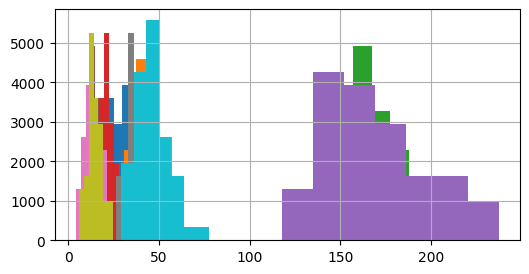

In [277]:
for cause_name in df["cause"].unique():
    mask = (df["cause"] == cause_name)
    number_of_observations = df[mask]["death_rate"].nunique()
    # Rice's rule
    suggested_bin_count = int(math.cbrt(number_of_observations)*2)
    print(f"{suggested_bin_count} for {cause_name}.")
    df[mask]["death_rate"].hist(bins=suggested_bin_count, figsize=(6, 3))

In [278]:
try:
    df.drop(columns=["death_rate_bin"], inplace=True)
except KeyError:
    pass

all_labels_df = pd.DataFrame()

for cause_name in df["cause"].unique():
    mask = (df["cause"] == cause_name)
    cause_labels = pd.qcut(df[mask]["death_rate"], 7, labels=[XXSMALL, XSMALL, SMALL, MEDIUM, LARGE, XLARGE, XXLARGE])
    if all_labels_df.size:
        all_labels_df = pd.concat([all_labels_df, cause_labels])
    else:
        all_labels_df = cause_labels

all_labels_df.shape

(167280,)

In [279]:
df = df.merge(all_labels_df, left_index=True, right_index=True, suffixes=(None, "_bin"))
print(df["death_rate_bin"].value_counts())
print(f"{df.shape[0]:,} rows")
df.head(2)

death_rate_bin
xx-small    26240
medium      26240
x-small     22960
small       22960
large       22960
x-large     22960
xx-large    22960
Name: count, dtype: int64
167,280 rows


,cause,death_rate,death_rate_normalized,population,legal_form,business_type,establishments_per_person,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin,death_rate_bin
0,Alzheimer's disease,35.2625,0.038138,4903185,9101,113,0.000003,150692.307692,xx-small,x-small,x-large,x-large
1,Alzheimer's disease,35.2625,0.038138,4903185,9111,113,0.000009,168533.333333,xx-small,medium,xx-large,x-large


## Census codes
Up to now we've been using the census codes for
* business_type (e.g. '111' is "Crop Production") ... a/k/a NAIC code
* legal_form (e.g. '920' is "Individual Proprietor")

We can convert these to the human-readable label.

I've gone to the trouble of downloading these, because the Census people don't make this information easy to work with (see the Original links below).
* North American Industry Classification System (aka NAIC)
  * [Original](https://www.census.gov/naics/?58967?yearbck=2017)
  * [Version used here](https://github.com/jsf80238/data_science/blob/main/data_files/naics_codes.csv)
* Legal Form of Organization
  * [Original](https://www2.census.gov/programs-surveys/abs/technical-documentation/api/NESD-Technical-Employer-and-Nonemployer-API-5242022Final.pdf)
  * [Version used here](https://github.com/jsf80238/data_science/blob/main/data_files/legal_form_codes.csv)

In [280]:
# The text format from the Census can be improved
def reformat_column_name(s: str) -> str:
    s = re.sub(r"\W", "_", s)
    s = s.replace("__", "_")
    s = re.sub(r"_$", "", s)
    return s.lower()


In [281]:
LEGAL_FORM_URL = "https://raw.githubusercontent.com/jsf80238/data_science/main/data_files/legal_form_codes.csv"
response = requests.get(LEGAL_FORM_URL)
line_list = response.text.splitlines()

legal_form_dict = dict()
csvreader = csv.DictReader(line_list)
label_for_keys, label_for_values = csvreader.fieldnames
for row in csvreader:
    nominal_label = row[label_for_values]
    improved_label = reformat_column_name(nominal_label)
    legal_form_dict[row[label_for_keys]] = improved_label

df["legal_form"] = df["legal_form"].apply(lambda x: legal_form_dict.get(x))
print(f"{df.shape[0]:,} rows")
df.head(2)

167,280 rows


,cause,death_rate,death_rate_normalized,population,legal_form,business_type,establishments_per_person,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin,death_rate_bin
0,Alzheimer's disease,35.2625,0.038138,4903185,c_corp,113,0.000003,150692.307692,xx-small,x-small,x-large,x-large
1,Alzheimer's disease,35.2625,0.038138,4903185,s_corp,113,0.000009,168533.333333,xx-small,medium,xx-large,x-large


In [282]:
BUSINESS_TYPE_URL = "https://raw.githubusercontent.com/jsf80238/data_science/main/data_files/naics_codes.csv"
response = requests.get(BUSINESS_TYPE_URL)
line_list = response.text.splitlines()

business_type_dict = dict()
csvreader = csv.DictReader(line_list)
label_for_keys, label_for_values = csvreader.fieldnames
for row in csvreader:
    nominal_label = row[label_for_values]
    improved_label = reformat_column_name(nominal_label)
    business_type_dict[row[label_for_keys]] = improved_label

df["business_type"] = df["business_type"].apply(lambda x: business_type_dict.get(x))
print(f"{df.shape[0]:,} rows")
df.head(2)

167,280 rows


,cause,death_rate,death_rate_normalized,population,legal_form,business_type,establishments_per_person,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin,death_rate_bin
0,Alzheimer's disease,35.2625,0.038138,4903185,c_corp,forestry_and_logging,0.000003,150692.307692,xx-small,x-small,x-large,x-large
1,Alzheimer's disease,35.2625,0.038138,4903185,s_corp,forestry_and_logging,0.000009,168533.333333,xx-small,medium,xx-large,x-large


## More cleanup
* Scale numeric features.
* Convert legal_form and business_type to Pandas categories.
* Encode the categorical data to 0/1:
  * Legal form
  * Business type
  * Population
  * Establishments
  * Revenue


### Scaling
See https://www.simplilearn.com/normalization-vs-standardization-article.
* Normalization: centered on 0 with standard deviation of 1 (and no effect on outliers).
* Standardization: lowest/highest values become 0 and 1.

In [283]:
scaling_df = pd.DataFrame()

numeric_column_list = df.select_dtypes(include=["float64", "int64"]).columns
to_be_scaled_column_list = [x for x in numeric_column_list if not x.startswith("death")]
for column_name in to_be_scaled_column_list:
        scaling_df[column_name] = df[column_name].copy()

scaler = MinMaxScaler()
scaling_df = pd.DataFrame(scaler.fit_transform(scaling_df), columns=to_be_scaled_column_list)

scaling_df

,population,establishments_per_person,revenue_per_establishment
0,0.111072,0.000121,0.183268
1,0.111072,0.000418,0.204966
2,0.111072,0.011352,0.067836
3,0.111072,0.000613,0.253609
4,0.111072,0.000102,0.167722
...,...,...,...
167275,0.000000,0.000000,0.000000
167276,0.000000,0.000000,0.000000
167277,0.000000,0.000000,0.000000
167278,0.000000,0.000000,0.000000


#### Add scaled columns to master dataframe

In [284]:
df = df.merge(scaling_df, left_index=True, right_index=True, suffixes=(None, "_scaled"))
print(f"{df.shape[0]:,} rows")
df.head(2)

167,280 rows


,cause,death_rate,death_rate_normalized,population,legal_form,business_type,establishments_per_person,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin,death_rate_bin,population_scaled,establishments_per_person_scaled,revenue_per_establishment_scaled
0,Alzheimer's disease,35.2625,0.038138,4903185,c_corp,forestry_and_logging,0.000003,150692.307692,xx-small,x-small,x-large,x-large,0.111072,0.000121,0.183268
1,Alzheimer's disease,35.2625,0.038138,4903185,s_corp,forestry_and_logging,0.000009,168533.333333,xx-small,medium,xx-large,x-large,0.111072,0.000418,0.204966


### Categorization

## Create revenue and establishments by legal form and business type
For example, suppose we have a row with these values:
* `establishments_per_person_scaled` = 0.123
* `revenue_per_establishment_scaled` = 0.456
* `legal_form` = 'c_corp'
* `business_type` = 'chemical_manufacturing'

That row will be updated to contain for example these columns (and many more columns for the many different legal forms and business types:
| air_transportation_</br>establishments_</br>per_person | air_transportation_</br>revenue_per_</br>establishment | chemical_manufacturing_</br>establishments_</br>per_person | chemical_manufacturing_</br>revenue_per_</br>establishment | gasoline_stations_</br>establishments_</br>per_person | gasoline_stations_</br>revenue_per_</br>establishment | c_corp_</br>establishments_</br>per_person | c_corp_</br>revenue_per_</br>establishment | partnership_</br>establishments_</br>per_person | partnership_</br>revenue_per_</br>establishment | 
| - | - | - | - | - | - | - | - | - | - |
| 0 | 0 | 0.123 | 0.456 | 0 | 0 | 0.123 | 0.456 | 0 | 0 |

In [285]:
df = pd.get_dummies(df, columns=["legal_form", "business_type"], dtype=int)
df.head(2)

,cause,death_rate,death_rate_normalized,population,establishments_per_person,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin,death_rate_bin,...,business_type_textile_product_mills,business_type_transit_and_ground_passenger_transportation,business_type_transportation_equipment_manufacturing,business_type_truck_transportation,business_type_utilities,business_type_warehousing_and_storage,business_type_waste_management_and_remediation_services,business_type_water_transportation,business_type_wholesale_electronic_markets_and_agents_and_brokers,business_type_wood_product_manufacturing
0,Alzheimer's disease,35.2625,0.038138,4903185,0.000003,150692.307692,xx-small,x-small,x-large,x-large,...,0,0,0,0,0,0,0,0,0,0
1,Alzheimer's disease,35.2625,0.038138,4903185,0.000009,168533.333333,xx-small,medium,xx-large,x-large,...,0,0,0,0,0,0,0,0,0,0


### Add columns

In [286]:
column_list = list(df.columns)
legal_form_list = [x for x in column_list if x.startswith(legal_form)]
business_type_list = [x for x in column_list if x.startswith(business_type)]

establishments_per_person = "establishments_per_person"
revenue_per_establishment = "revenue_per_establishment"
business_type = "business_type"
legal_form = "legal_form"
scaled = "scaled"

In [287]:
for item in legal_form_list:
    establishments_column_name = item + "_" + establishments_per_person
    df[establishments_column_name] = df[establishments_per_person + "_" + scaled] * df[item]
    revenue_column_name = item + "_" + revenue_per_establishment
    df[revenue_column_name] = df[revenue_per_establishment + "_" + scaled] * df[item]

In [288]:
for item in business_type_list:
    establishments_column_name = item + "_" + establishments_per_person
    df[establishments_column_name] = df[establishments_per_person + "_" + scaled] * df[item]
    revenue_column_name = item + "_" + revenue_per_establishment
    df[revenue_column_name] = df[revenue_per_establishment + "_" + scaled] * df[item]

/tmp/ipykernel_118067/2929001716.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[revenue_column_name] = df[revenue_per_establishment + "_" + scaled] * df[item]
/tmp/ipykernel_118067/2929001716.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[establishments_column_name] = df[establishments_per_person + "_" + scaled] * df[item]
/tmp/ipykernel_118067/2929001716.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

### Performance warning & cleanup
We'll take care of the `PerformanceWarning: DataFrame is highly fragmented.` warning in a bit. See https://stackoverflow.com/questions/68292862/performancewarning-dataframe-is-highly-fragmented-this-is-usually-the-result-o.

In the meantime, we no longer need the "dummies" columns, for example:
* legal_form_s_corp
* business_type_accommodation

In [291]:
columns_to_drop_list = list()
for column_name in df.columns:
    if column_name.startswith(legal_form) or column_name.startswith(business_type):
        if not column_name.endswith(establishments_per_person) and not column_name.endswith(revenue_per_establishment):
            columns_to_drop_list.append(column_name)
df.drop(columns=columns_to_drop_list, inplace=True)
print(df.info())
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167280 entries, 0 to 167279
Columns: 185 entries, cause to business_type_wood_product_manufacturing_revenue_per_establishment
dtypes: category(4), float64(179), int64(1), object(1)
memory usage: 231.6+ MB
None


,cause,death_rate,death_rate_normalized,population,establishments_per_person,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin,death_rate_bin,...,business_type_warehousing_and_storage_establishments_per_person,business_type_warehousing_and_storage_revenue_per_establishment,business_type_waste_management_and_remediation_services_establishments_per_person,business_type_waste_management_and_remediation_services_revenue_per_establishment,business_type_water_transportation_establishments_per_person,business_type_water_transportation_revenue_per_establishment,business_type_wholesale_electronic_markets_and_agents_and_brokers_establishments_per_person,business_type_wholesale_electronic_markets_and_agents_and_brokers_revenue_per_establishment,business_type_wood_product_manufacturing_establishments_per_person,business_type_wood_product_manufacturing_revenue_per_establishment
0,Alzheimer's disease,35.2625,0.038138,4903185,0.000003,150692.307692,xx-small,x-small,x-large,x-large,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alzheimer's disease,35.2625,0.038138,4903185,0.000009,168533.333333,xx-small,medium,xx-large,x-large,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [292]:
# Address performance warning
temp_df = df.copy()
df = temp_df.copy()
del(temp_df)
print(f"{df.shape[0]:,} rows")
df.head(2)

51 rows


,cause,death_rate,death_rate_normalized,population,establishments_per_person,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin,death_rate_bin,...,business_type_warehousing_and_storage_establishments_per_person,business_type_warehousing_and_storage_revenue_per_establishment,business_type_waste_management_and_remediation_services_establishments_per_person,business_type_waste_management_and_remediation_services_revenue_per_establishment,business_type_water_transportation_establishments_per_person,business_type_water_transportation_revenue_per_establishment,business_type_wholesale_electronic_markets_and_agents_and_brokers_establishments_per_person,business_type_wholesale_electronic_markets_and_agents_and_brokers_revenue_per_establishment,business_type_wood_product_manufacturing_establishments_per_person,business_type_wood_product_manufacturing_revenue_per_establishment
0,Alzheimer's disease,35.2625,0.038138,4903185,0.000003,150692.307692,xx-small,x-small,x-large,x-large,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alzheimer's disease,35.2625,0.038138,4903185,0.000009,168533.333333,xx-small,medium,xx-large,x-large,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create different frames for each cause of death
The features leading to a higher death rate might be different based on cause of death.

We will analyze each separately.

In [61]:
frames_by_cause_dict = dict()
for cause_name in df["cause"].unique():
    mask = (df["cause"] == cause_name)
    new_df = df[mask].copy()
    new_df.drop(columns=["cause"], inplace=True)
    frames_by_cause_dict[cause_name] = new_df

frames_by_cause_dict["Heart disease"]

,death_rate,death_rate_normalized,population,establishments_pp,revenue_per_establishment,population_bin,establishments_bin,revenue_per_establishment_bin,death_rate_bin,population_scaled,...,business_type_textile_product_mills,business_type_transit_and_ground_passenger_transportation,business_type_transportation_equipment_manufacturing,business_type_truck_transportation,business_type_utilities,business_type_warehousing_and_storage,business_type_waste_management_and_remediation_services,business_type_water_transportation,business_type_wholesale_electronic_markets_and_agents_and_brokers,business_type_wood_product_manufacturing
1312,227.200,0.245725,4903185,0.000003,150692.307692,xx-small,x-small,x-large,xx-large,0.111072,...,0,0,0,0,0,0,0,0,0,0
1313,227.200,0.245725,4903185,0.000009,168533.333333,xx-small,medium,xx-large,xx-large,0.111072,...,0,0,0,0,0,0,0,0,0,0
1314,227.200,0.245725,4903185,0.000249,55778.413737,xx-small,xx-large,small,xx-large,0.111072,...,0,0,0,0,0,0,0,0,0,0
1315,227.200,0.245725,4903185,0.000013,208530.303030,xx-small,medium,xx-large,xx-large,0.111072,...,0,0,0,0,0,0,0,0,0,0
1316,227.200,0.245725,4903185,0.000002,137909.090909,xx-small,x-small,x-large,xx-large,0.111072,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165635,159.575,0.214930,578759,0.000000,0.000000,xx-small,xx-small,xx-small,medium,0.000000,...,0,0,0,0,0,0,0,0,0,0
165636,159.575,0.214930,578759,0.000000,0.000000,xx-small,xx-small,xx-small,medium,0.000000,...,0,0,1,0,0,0,0,0,0,0
165637,159.575,0.214930,578759,0.000000,0.000000,xx-small,xx-small,xx-small,medium,0.000000,...,0,0,0,0,0,0,0,0,0,0
165638,159.575,0.214930,578759,0.000000,0.000000,xx-small,xx-small,xx-small,medium,0.000000,...,0,0,0,0,0,0,0,0,0,0


## Heart Disease
Let's see if we can find factors which predict the death rate from heart disease.
* Linear regression

The requirements for linear regression are:
* The observations must be independent.
  * We're going to assume they were.
* Continuous predictors are linearly related to the outcome (linearity).
  * We'll find out.
* There should be little multicollinearity among independent variables.
  * We did this earlier.

In [58]:
list(frames_by_cause_dict["Heart disease"].columns)

['death_rate',
 'death_rate_normalized',
 'population',
 'establishments_pp',
 'revenue_per_establishment',
 'population_bin',
 'establishments_bin',
 'revenue_per_establishment_bin',
 'death_rate_bin',
 'population_scaled',
 'establishments_pp_scaled',
 'revenue_per_establishment_scaled',
 'legal_form_Individual_Proprietor',
 'legal_form_Partnership',
 'legal_form_S_Corp',
 'business_type_Administrative_and_Support_Services',
 'business_type_Air_Transportation',
 'business_type_Ambulatory_Health_Care_Services',
 'business_type_Amusement_Gambling_and_Recreation_Industries',
 'business_type_Apparel_Manufacturing',
 'business_type_Beverage_and_Tobacco_Product_Manufacturing',
 'business_type_Broadcasting_except_Internet',
 'business_type_Building_Material_and_Garden_Equipment_and_Supplies_Dealers',
 'business_type_Chemical_Manufacturing',
 'business_type_Clothing_and_Clothing_Accessories_Stores',
 'business_type_Computer_and_Electronic_Product_Manufacturing',
 'business_type_Construction_

In [579]:
this_df = frames_by_cause_dict["Heart disease"]
X_column_list = list(this_df.columns)
X_column_list.remove("death_rate")
X_column_list.remove("death_rate_normalized")
X_column_list.remove("population")
X_column_list.remove("establishments_per_person")
X_column_list.remove("revenue_per_establishment")
X_column_list.remove("population_bin")
X_column_list.remove("establishments_bin")
X_column_list.remove("revenue_per_establishment_bin")
X_column_list.remove("death_rate_bin")

ols_formula = "death_rate_normalized ~ "
ols_formula += " + ".join(X_column_list)
ordinary_least_square = ols(formula=ols_formula, data=this_df)

In [581]:
model = ordinary_least_square.fit()
model